In [ ]:
import os
import re
import random
import time
from glob import glob
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast

import torchvision
import torchvision.transforms as T
import torchvision.io as io
from torchvision.models.video import r3d_18, r2plus1d_18

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from tqdm import tqdm
import cv2
import numpy as np
import traceback

import json
import pandas as pd
import gc

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
BASE_DIR = "/kaggle/input/ultrasound/SYSU-CEUS-FLL"

# Training / data config
BATCH_SIZE = 4
NUM_WORKERS = 4
NUM_EPOCHS = 5
LR = 1e-4
NUM_CLASSES = 2          # binary: 0=Benign, 1=Malignant
BENIGN_FOLDERS = ["FNC", "HHE", "HCC"]

In [ ]:
binary_label_map = {"HCC": 1, "HHE": 0, "FNH": 0}

all_records = []
for cls in ["HCC", "HHE", "FNH"]:
    cls_dir = os.path.join(BASE_DIR, cls)
    if not os.path.isdir(cls_dir):
        print("Warning: missing folder", cls_dir)
        continue
    for p in sorted(glob(os.path.join(cls_dir, "*.avi"))):
        all_records.append({"path": p, "label": binary_label_map[cls]})

print("Tổng video tìm được:", len(all_records))
print("Phân bố labels:", Counter([r['label'] for r in all_records]))

Tổng video tìm được: 358
Phân bố labels: Counter({1: 186, 0: 172})


In [ ]:
all_records = []
class_folders = [d for d in sorted(os.listdir(BASE_DIR)) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Found class folders:", class_folders)

for cls in class_folders:
    cls_dir = os.path.join(BASE_DIR, cls)
    avi_files = sorted(glob(os.path.join(cls_dir, "*.avi")))
    # Decide label: HCC => 1, others in BENIGN_FOLDERS => 0, if unknown folder name, treat as benign
    if cls.upper() == "HCC":
        label = 1
    else:
        label = 0
    for p in avi_files:
        all_records.append({"path": p, "label": label, "class_name": cls})

print("Total videos:", len(all_records))
print("Label distribution (0=Benign,1=Malignant):", Counter([r['label'] for r in all_records]))
print("Counts per folder:", {k: sum(1 for r in all_records if r['class_name']==k) for k in class_folders})


Found class folders: ['FNH', 'HCC', 'HHE']
Total videos: 358
Label distribution (0=Benign,1=Malignant): Counter({1: 186, 0: 172})
Counts per folder: {'FNH': 60, 'HCC': 186, 'HHE': 112}


In [ ]:
labels = [r['label'] for r in all_records]
train_records, temp_records = train_test_split(all_records, test_size=0.20, stratify=labels, random_state=SEED)
val_records, test_records = train_test_split(temp_records, test_size=0.50, stratify=[r['label'] for r in temp_records], random_state=SEED)

print("Train/Val/Test counts:", len(train_records), len(val_records), len(test_records))
print("Train dist:", Counter([r['label'] for r in train_records]))
print("Val dist:",   Counter([r['label'] for r in val_records]))
print("Test dist:",  Counter([r['label'] for r in test_records]))


Train/Val/Test counts: 286 36 36
Train dist: Counter({1: 149, 0: 137})
Val dist: Counter({1: 19, 0: 17})
Test dist: Counter({0: 18, 1: 18})


In [ ]:
class VideoClipDataset(Dataset):
    def __init__(self, records, target_frames=32, transform=None):
        """
        records: list chứa (path, label) hoặc [path, label]
        target_frames: số frame mong muốn cho mỗi clip
        transform: torchvision transform áp dụng cho từng frame
        """
        self.records = records
        self.target_frames = target_frames
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        record = self.records[idx]

        if isinstance(record, (tuple, list)) and len(record) >= 2:
            path, label = record[0], record[1]
        elif isinstance(record, dict) and "path" in record and "label" in record:
            path, label = record["path"], record["label"]
        else:
            raise ValueError(f"Record format không hợp lệ: {record}")

        # --- Load video bằng OpenCV ---
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR -> RGB
            frames.append(frame)
        cap.release()

        # Nếu video rỗng
        if len(frames) == 0:
            raise ValueError(f"Video {path} không đọc được!")

        # --- Chọn target_frames ---
        total_frames = len(frames)
        if total_frames >= self.target_frames:
            idxs = np.linspace(0, total_frames - 1, self.target_frames, dtype=int)
            frames = [frames[i] for i in idxs]
        else:
            # Lặp lại frame nếu video ngắn hơn
            repeat = (self.target_frames + total_frames - 1) // total_frames
            frames = (frames * repeat)[:self.target_frames]

        # --- Transform từng frame ---
        processed = []
        for frame in frames:
            frame_tensor = torch.from_numpy(frame).permute(2, 0, 1)  # HWC -> CHW
            if self.transform:
                frame_tensor = self.transform(frame_tensor)
            processed.append(frame_tensor)

        # --- Stack thành tensor ---
        video_tensor = torch.stack(processed, dim=0)  # [T, C, H, W]
        video_tensor = video_tensor.permute(1, 0, 2, 3)  # -> [C, T, H, W]

        label = torch.tensor(label, dtype=torch.long)
        return video_tensor, label


In [ ]:
TARGET_FRAMES = 32
FRAME_SIZE = 128

# Transform cho video siêu âm CEUS
per_frame_transform = T.Compose([
    T.Resize((FRAME_SIZE, FRAME_SIZE)),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5])
])

# Dataset & DataLoader
train_ds = VideoClipDataset(train_records, target_frames=TARGET_FRAMES, transform=per_frame_transform)
val_ds   = VideoClipDataset(val_records,   target_frames=TARGET_FRAMES, transform=per_frame_transform)
test_ds  = VideoClipDataset(test_records,  target_frames=TARGET_FRAMES, transform=per_frame_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

print("Batches (train/val/test):", len(train_loader), len(val_loader), len(test_loader))

Batches (train/val/test): 72 9 9


In [ ]:
def get_r3d(num_classes=2, pretrained=True):
    model = r3d_18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_r2plus1d(num_classes=2, pretrained=True):
    model = r2plus1d_18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

class Transformer_LSTM(nn.Module):
    """2D ResNet18 backbone + Transformer Encoder + BiLSTM"""
    def __init__(self, num_classes=2, hidden_size=256, nhead=4, num_layers=2, pretrained=True):
        super().__init__()
        base = torchvision.models.resnet18(pretrained=pretrained)
        self.feature_extractor = nn.Sequential(*list(base.children())[:-2])  # bỏ FC
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        feat_dim = 512  # ResNet18 output

        # projection để match với hidden size
        self.proj = nn.Linear(feat_dim, hidden_size)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # BiLSTM sau Transformer
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)

        # Classifier
        self.classifier = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # x: [B, C, T, H, W]
        B, C, T, H, W = x.shape
        xt = x.permute(0,2,1,3,4).reshape(B*T, C, H, W)    # [B*T, C, H, W]

        # CNN feature
        feats = self.feature_extractor(xt)                 # [B*T, 512, Hf, Wf]
        feats = self.global_pool(feats).view(B, T, -1)     # [B, T, feat_dim]

        # projection
        feats = self.proj(feats)                           # [B, T, hidden_size]

        # transformer encoder
        feats = self.transformer(feats)                    # [B, T, hidden_size]

        # BiLSTM
        out, _ = self.lstm(feats)                          # [B, T, hidden*2]

        # lấy last timestep
        out = out[:, -1, :]                                # [B, hidden*2]

        # classifier
        logits = self.classifier(out)                      # [B, num_classes]
        return logits

class CNN_LSTM(nn.Module):
    """2D ResNet18 backbone + BiLSTM"""
    def __init__(self, num_classes=2, hidden_size=256, pretrained=True):
        super().__init__()
        base = torchvision.models.resnet18(pretrained=pretrained)
        self.feature_extractor = nn.Sequential(*list(base.children())[:-2])  # till conv layers
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        feat_dim = 512
        self.lstm = nn.LSTM(feat_dim, hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # x: [B, C, T, H, W]
        B, C, T, H, W = x.shape
        xt = x.permute(0,2,1,3,4).reshape(B*T, C, H, W)    # [B*T, C, H, W]
        feats = self.feature_extractor(xt)                 # [B*T, 512, Hf, Wf]
        feats = self.global_pool(feats).view(B, T, -1)     # [B, T, feat_dim]
        out, _ = self.lstm(feats)                          # [B, T, hidden*2]
        out = out[:, -1, :]                                # last timestep
        logits = self.classifier(out)
        return logits

In [ ]:
criterion = nn.CrossEntropyLoss()

# Detect GPU & AMP
USE_AMP = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "| AMP:", USE_AMP)


def train_one_epoch(model, loader, optimizer, scaler=None, device=device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc="Train", leave=False)
    for xb, yb in loop:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()

        if scaler is not None and USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    return running_loss / total, correct / total


def evaluate(model, loader, return_probs=True, device=device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        loop = tqdm(loader, desc="Eval", leave=False)
        for xb, yb in loop:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            if USE_AMP:
                with torch.cuda.amp.autocast():
                    logits = model(xb)
                    loss = criterion(logits, yb)
            else:
                logits = model(xb)
                loss = criterion(logits, yb)

            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            running_loss += loss.item() * xb.size(0)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    if total == 0:
        return None

    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    if return_probs:
        return running_loss / total, correct / total, all_labels, all_preds, all_probs
    else:
        return running_loss / total, correct / total, all_labels, all_preds

Using device: cuda | AMP: True


Using device: cuda

RUNNING MODEL: r3d


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 184MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[r3d] Epoch 1/5


Train:   0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_36/2025512485.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/9 [00:00<?, ?it/s]                                  /tmp/ipykernel_36/2025512485.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


 Train Loss=0.6183, Acc=0.6434  |  Val Loss=0.5145206451416016, Val Acc=0.7222222222222222
  Saved best model -> ./runs_all_models/best_model_r3d.pth
[r3d] Epoch 2/5


 Train Loss=0.4259, Acc=0.8077  |  Val Loss=1.1331999037000868, Val Acc=0.5555555555555556
[r3d] Epoch 3/5


 Train Loss=0.4056, Acc=0.8182  |  Val Loss=0.5453470018174913, Val Acc=0.6388888888888888
  Early stopping (no improvement for 2 epochs).
 Saved history -> ./runs_all_models/history_r3d.json
 Loaded best checkpoint for testing.


[r3d] Test Loss=0.7469, Test Acc=0.6389

Classification Report:
              precision    recall  f1-score   support

      Benign     0.5926    0.8889    0.7111        18
   Malignant     0.7778    0.3889    0.5185        18

    accuracy                         0.6389        36
   macro avg     0.6852    0.6389    0.6148        36
weighted avg     0.6852    0.6389    0.6148        36



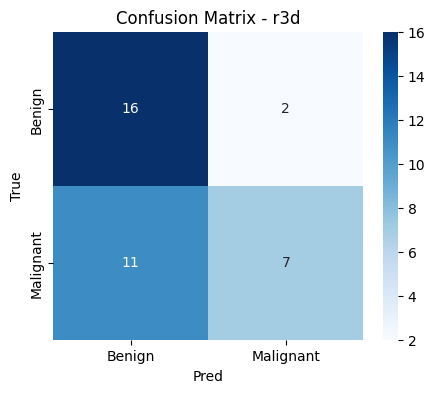

ROC AUC: 0.7854938271604939

RUNNING MODEL: r2plus1d


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 218MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

[r2plus1d] Epoch 1/5


Train:   0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_36/2025512485.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/9 [00:00<?, ?it/s]                                  /tmp/ipykernel_36/2025512485.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


 Train Loss=0.6443, Acc=0.6713  |  Val Loss=0.5314721001519097, Val Acc=0.75
  Saved best model -> ./runs_all_models/best_model_r2plus1d.pth
[r2plus1d] Epoch 2/5


 Train Loss=0.5352, Acc=0.7343  |  Val Loss=0.43077829149034286, Val Acc=0.8611111111111112
  Saved best model -> ./runs_all_models/best_model_r2plus1d.pth
[r2plus1d] Epoch 3/5


 Train Loss=0.4246, Acc=0.8007  |  Val Loss=0.5045818222893609, Val Acc=0.7222222222222222
[r2plus1d] Epoch 4/5


 Train Loss=0.3787, Acc=0.8357  |  Val Loss=0.3451282713148329, Val Acc=0.8055555555555556
  Early stopping (no improvement for 2 epochs).
 Saved history -> ./runs_all_models/history_r2plus1d.json
 Loaded best checkpoint for testing.


[r2plus1d] Test Loss=0.8427, Test Acc=0.6111

Classification Report:
              precision    recall  f1-score   support

      Benign     0.8333    0.2778    0.4167        18
   Malignant     0.5667    0.9444    0.7083        18

    accuracy                         0.6111        36
   macro avg     0.7000    0.6111    0.5625        36
weighted avg     0.7000    0.6111    0.5625        36



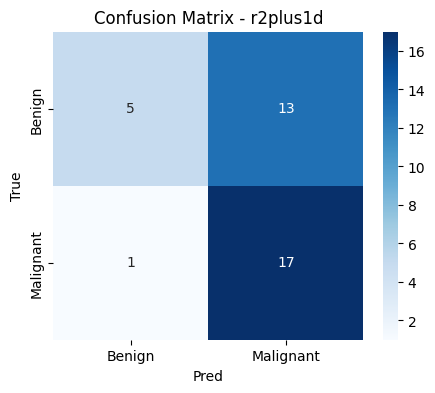

ROC AUC: 0.7685185185185185

RUNNING MODEL: cnn_lstm


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

[cnn_lstm] Epoch 1/5


Train:   0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_36/2025512485.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/9 [00:00<?, ?it/s]                                  /tmp/ipykernel_36/2025512485.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


 Train Loss=0.6761, Acc=0.6329  |  Val Loss=0.5308329264322916, Val Acc=0.7777777777777778
  Saved best model -> ./runs_all_models/best_model_cnn_lstm.pth
[cnn_lstm] Epoch 2/5


 Train Loss=0.4917, Acc=0.7727  |  Val Loss=0.6048855251736112, Val Acc=0.7222222222222222
[cnn_lstm] Epoch 3/5


 Train Loss=0.3266, Acc=0.8601  |  Val Loss=0.5508172776963975, Val Acc=0.75
  Early stopping (no improvement for 2 epochs).
 Saved history -> ./runs_all_models/history_cnn_lstm.json
 Loaded best checkpoint for testing.


[cnn_lstm] Test Loss=0.5632, Test Acc=0.6667

Classification Report:
              precision    recall  f1-score   support

      Benign     0.6667    0.6667    0.6667        18
   Malignant     0.6667    0.6667    0.6667        18

    accuracy                         0.6667        36
   macro avg     0.6667    0.6667    0.6667        36
weighted avg     0.6667    0.6667    0.6667        36



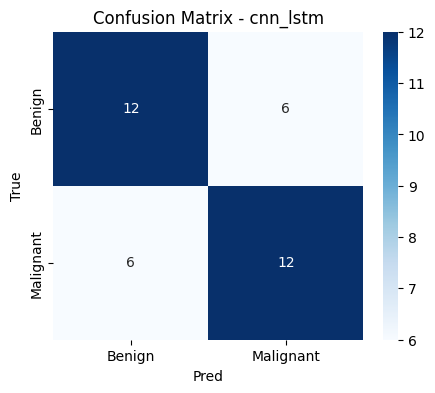

ROC AUC: 0.8132716049382716

RUNNING MODEL: transformer_lstm


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[transformer_lstm] Epoch 1/5


Train:   0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_36/2025512485.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Eval:   0%|          | 0/9 [00:00<?, ?it/s]                                  /tmp/ipykernel_36/2025512485.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


 Train Loss=0.7041, Acc=0.5594  |  Val Loss=0.5952623155381944, Val Acc=0.7777777777777778
  Saved best model -> ./runs_all_models/best_model_transformer_lstm.pth
[transformer_lstm] Epoch 2/5


 Train Loss=0.5494, Acc=0.7448  |  Val Loss=0.4711778428819444, Val Acc=0.8055555555555556
  Saved best model -> ./runs_all_models/best_model_transformer_lstm.pth
[transformer_lstm] Epoch 3/5


 Train Loss=0.4573, Acc=0.7972  |  Val Loss=0.7066413031684028, Val Acc=0.5277777777777778
[transformer_lstm] Epoch 4/5


 Train Loss=0.4232, Acc=0.8182  |  Val Loss=0.4090338812934028, Val Acc=0.8055555555555556
  Early stopping (no improvement for 2 epochs).
 Saved history -> ./runs_all_models/history_transformer_lstm.json
 Loaded best checkpoint for testing.


[transformer_lstm] Test Loss=0.5106, Test Acc=0.7778

Classification Report:
              precision    recall  f1-score   support

      Benign     0.7778    0.7778    0.7778        18
   Malignant     0.7778    0.7778    0.7778        18

    accuracy                         0.7778        36
   macro avg     0.7778    0.7778    0.7778        36
weighted avg     0.7778    0.7778    0.7778        36



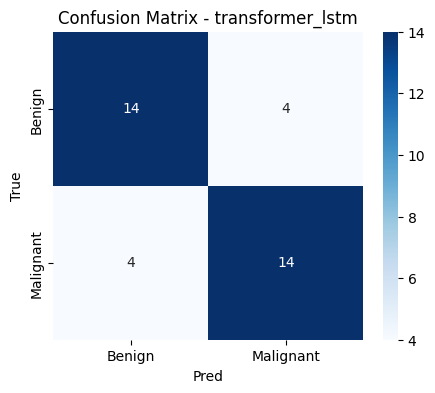

ROC AUC: 0.8611111111111112

All runs finished. Summary saved to: ./runs_all_models/results_summary.csv


,model,best_val_acc,best_epoch,test_loss,test_acc
0,r3d,0.722222,1,0.746944,0.638889
1,r2plus1d,0.861111,2,0.842687,0.611111
2,cnn_lstm,0.777778,1,0.563168,0.666667
3,transformer_lstm,0.805556,2,0.510627,0.777778


In [ ]:
print("Using device:", device)

MODELS_TO_RUN = ['r3d', 'r2plus1d', 'cnn_lstm', 'transformer_lstm']
EPOCHS_PER_MODEL = NUM_EPOCHS
LR_PER_MODEL = LR
PATIENCE = 2
MIN_DELTA = 1e-4
OUTPUT_DIR = "./runs_all_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

summary = []

for model_name in MODELS_TO_RUN:
    print("\n" + "="*60)
    print(f"RUNNING MODEL: {model_name}")
    print("="*60)
    try:
        # init model
        if model_name == 'r3d':
            model = get_r3d(num_classes=NUM_CLASSES, pretrained=True)
        elif model_name == 'r2plus1d':
            model = get_r2plus1d(num_classes=NUM_CLASSES, pretrained=True)
        elif model_name == 'cnn_lstm':
            model = CNN_LSTM(num_classes=NUM_CLASSES, pretrained=True)
        elif model_name == 'transformer_lstm':
            model = Transformer_LSTM(num_classes=NUM_CLASSES, pretrained=True)
        else:
            raise ValueError("Unknown model: " + model_name)

        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR_PER_MODEL)
        # reduce LR on plateau (monitor val acc -> mode='max')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
        scaler = torch.amp.GradScaler() if USE_AMP else None

        best_val_acc = 0.0
        best_epoch = -1
        no_improve = 0
        history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

        for epoch in range(EPOCHS_PER_MODEL):
            print(f"[{model_name}] Epoch {epoch+1}/{EPOCHS_PER_MODEL}")
            t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, scaler)
            res = evaluate(model, val_loader)
            if res is None:
                v_loss, v_acc = None, None
            else:
                v_loss, v_acc, _, _, _ = res

            history["train_loss"].append(t_loss); history["train_acc"].append(t_acc)
            history["val_loss"].append(v_loss); history["val_acc"].append(v_acc)
            print(f" Train Loss={t_loss:.4f}, Acc={t_acc:.4f}  |  Val Loss={v_loss}, Val Acc={v_acc}")

            # scheduler step uses val metric (acc) if available
            if v_acc is not None:
                scheduler.step(v_acc)

            # early stopping & save best
            improved = False
            if v_acc is not None and (v_acc - best_val_acc) > MIN_DELTA:
                improved = True
                best_val_acc = v_acc
                best_epoch = epoch + 1
                ckpt = os.path.join(OUTPUT_DIR, f"best_model_{model_name}.pth")
                torch.save(model.state_dict(), ckpt)
                print("  Saved best model ->", ckpt)

            if improved:
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= PATIENCE:
                print(f"  Early stopping (no improvement for {PATIENCE} epochs).")
                break

        # save history
        hist_path = os.path.join(OUTPUT_DIR, f"history_{model_name}.json")
        with open(hist_path, "w") as f:
            json.dump(history, f)
        print(" Saved history ->", hist_path)

        # load best checkpoint if exists
        best_ckpt = os.path.join(OUTPUT_DIR, f"best_model_{model_name}.pth")
        if os.path.exists(best_ckpt):
            model.load_state_dict(torch.load(best_ckpt, map_location=device))
            model = model.to(device)
            print(" Loaded best checkpoint for testing.")

        # evaluate on test set
        test_res = evaluate(model, test_loader)
        if test_res is None:
            test_loss, test_acc, labels, preds, probs = (None, None, None, None, None)
        else:
            test_loss, test_acc, labels, preds, probs = test_res
            print(f"[{model_name}] Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

        # print classification report & confusion matrix if labels available
        classes = ["Benign", "Malignant"]
        if labels is not None:
            print("\nClassification Report:")
            print(classification_report(labels, preds, target_names=classes, digits=4))
            cm = confusion_matrix(labels, preds)
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
            plt.title(f"Confusion Matrix - {model_name}")
            plt.xlabel("Pred"); plt.ylabel("True")
            plt.show()
            if probs is not None and probs.shape[1] == 2:
                try:
                    auc = roc_auc_score(labels, probs[:,1])
                    print("ROC AUC:", auc)
                except Exception as e:
                    print("ROC AUC could not be computed:", e)

        # save per-model summary
        summary.append({
            "model": model_name,
            "best_val_acc": float(best_val_acc) if best_val_acc is not None else None,
            "best_epoch": int(best_epoch) if best_epoch is not None else None,
            "test_loss": float(test_loss) if test_loss is not None else None,
            "test_acc": float(test_acc) if test_acc is not None else None
        })

    except Exception as e:
        print(f"Error while running {model_name}: {e}")
        traceback.print_exc()
        summary.append({
            "model": model_name,
            "best_val_acc": None,
            "best_epoch": None,
            "test_loss": None,
            "test_acc": None,
            "error": str(e)
        })

    # cleanup
    try:
        del model, optimizer, scheduler, scaler
    except:
        pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    time.sleep(1)

# save summary CSV
summary_df = pd.DataFrame(summary)
summary_csv = os.path.join(OUTPUT_DIR, "results_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("\nAll runs finished. Summary saved to:", summary_csv)
display(summary_df)

,model,best_val_acc,best_epoch,test_loss,test_acc
0,r3d,0.722222,1,0.746944,0.638889
1,r2plus1d,0.861111,2,0.842687,0.611111
2,cnn_lstm,0.777778,1,0.563168,0.666667
3,transformer_lstm,0.805556,2,0.510627,0.777778


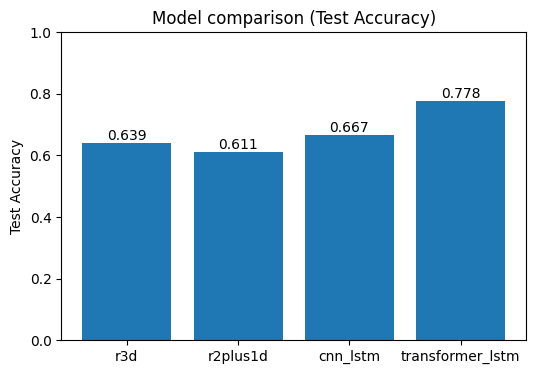

In [ ]:
if 'summary_df' in globals():
    display(summary_df)
    plt.figure(figsize=(6,4))
    df_plot = summary_df.dropna(subset=['test_acc'])
    plt.bar(df_plot['model'], df_plot['test_acc'])
    plt.ylim(0,1)
    plt.ylabel("Test Accuracy")
    plt.title("Model comparison (Test Accuracy)")
    for i,v in enumerate(df_plot['test_acc']):
        plt.text(i, v+0.01, f"{v:.3f}", ha='center')
    plt.show()
else:
    print("No summary_df found.")

## 1. Kết quả Huấn luyện và Đánh giá

### 1.1. Tổng quan Kết quả

| Mô hình            | Best Val Acc | Best Epoch | Test Loss | Test Acc |
|--------------------|--------------|------------|-----------|----------|
| r3d                | 0.7222       | 1          | 0.7469    | 0.6389   |
| r2plus1d           | 0.8611       | 2          | 0.8427    | 0.6111   |
| cnn_lstm           | 0.7778       | 1          | 0.5632    | 0.6667   |
| transformer_lstm   | 0.8056       | 2          | 0.5106    | 0.7778   |

---

### 1.2. Chi tiết Kết quả từng Mô hình

#### 🔹 r3d (3D ResNet18)
- **Epoch tốt nhất:** 1 (Val Acc: 0.7222)  
- **Test Acc:** 0.6389, **Test Loss:** 0.7469  
- **Classification Report:**
  - Benign: Precision 0.5926, Recall 0.8889, F1 0.7111  
  - Malignant: Precision 0.7778, Recall 0.3889, F1 0.5185  
- **ROC AUC:** 0.7855  
- **Nhận xét:** Recall cao cho *Benign* nhưng F1 thấp cho *Malignant* do mất cân bằng giữa recall và precision.  

---

#### 🔹 r2plus1d (R(2+1)D)
- **Epoch tốt nhất:** 2 (Val Acc: 0.8611)  
- **Test Acc:** 0.6111, **Test Loss:** 0.8427  
- **Classification Report:**
  - Benign: Precision 0.8333, Recall 0.2778, F1 0.4167  
  - Malignant: Precision 0.5667, Recall 0.9444, F1 0.7083  
- **ROC AUC:** 0.7685  
- **Nhận xét:** Recall cao cho *Malignant* nhưng precision thấp cho *Benign*, cho thấy mô hình thiên về phát hiện *Malignant*.  

---

#### 🔹 cnn_lstm
- **Epoch tốt nhất:** 1 (Val Acc: 0.7778)  
- **Test Acc:** 0.6667, **Test Loss:** 0.5632  
- **Classification Report:**
  - Benign: Precision 0.6667, Recall 0.6667, F1 0.6667  
  - Malignant: Precision 0.6667, Recall 0.6667, F1 0.6667  
- **ROC AUC:** 0.8133  
- **Nhận xét:** Hiệu suất cân bằng giữa hai lớp, F1 ổn định, phù hợp cho phân loại tổng quát.  

---

#### 🔹 transformer_lstm
- **Epoch tốt nhất:** 2 (Val Acc: 0.8056)  
- **Test Acc:** 0.7778, **Test Loss:** 0.5106  
- **Classification Report:**
  - Benign: Precision 0.7778, Recall 0.7778, F1 0.7778  
  - Malignant: Precision 0.7778, Recall 0.7778, F1 0.7778  
- **ROC AUC:** 0.8611  
- **Nhận xét:** Hiệu suất tốt nhất, cân bằng giữa precision và recall, ROC AUC cao nhất.  

---

## 2. Phân tích và Đánh giá

- **Hiệu suất tổng thể:**  
  `Transformer_lstm` đạt Test Acc cao nhất (**0.7778**) và ROC AUC cao nhất (**0.8611**), cho thấy khả năng phân loại tốt hơn nhờ kết hợp Transformer và LSTM.  

- **So sánh mô hình:**
  - `r3d` và `r2plus1d` (kiến trúc 3D) có hiệu suất trung bình.  
    - `r2plus1d` đạt Val Acc cao nhất (0.8611) nhưng Test Acc giảm (0.6111) → dấu hiệu **overfitting**.  
  - `cnn_lstm` cho hiệu suất cân bằng nhưng không vượt trội so với `transformer_lstm`.  

- **Yếu tố ảnh hưởng:**
  - **AMP** cải thiện hiệu suất GPU, nhưng warning liên quan `torch.cuda.amp.autocast` cho thấy cần cập nhật sang `torch.amp.autocast('cuda', ...)`.  
  - **Early stopping** hiệu quả, ngăn overfitting (r3d, r2plus1d, cnn_lstm dừng sớm).  
  - **Dung lượng mô hình:**  
    - r3d: 127MB, r2plus1d: 120MB, resnet18: 44.7MB  
    - Không ảnh hưởng lớn đến hiệu suất GPU.  

---

## 3. Kết luận và Đề xuất

- **Kết luận:**  
  `Transformer_lstm` là mô hình tốt nhất với **Test Acc = 0.7778** và **ROC AUC = 0.8611**, phù hợp cho ứng dụng phân loại video y học.  
